# Install Requirements

In [ ]:
# Install torch

!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -q torchinfo

Looking in indexes: https://download.pytorch.org/whl/cu121


# Import Libraries

In [ ]:
# Continue with regular imports

import matplotlib.pyplot as plt
import torch
import torchvision
import os
import zipfile
import requests
import numpy as np
import pandas as pd
import random
import csv
import ast
import pathlib

from torch import nn
from torchvision import transforms, datasets
from torchinfo import summary
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from pathlib import Path
from datetime import datetime
from timeit import default_timer as timer
from PIL import Image

In [ ]:
# Setup device

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Import data

In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
# Upload your own API Token from kaggle in Colab before running this cell
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d gpiosenka/100-bird-species

100% 1.95G/1.96G [00:54<00:00, 42.3MB/s]
100% 1.96G/1.96G [00:54<00:00, 38.5MB/s]


In [ ]:
! mkdir data

In [ ]:
! unzip 100-bird-species.zip -d data


In [ ]:
# Setup Directories

image_path = "/content/data"

train_dir = f"{image_path}/train"
test_dir = f"{image_path}/test"
valid_dir = f"{image_path}/valid"

In [ ]:
print(train_dir)

/content/data/train


# Helper Functions

## Set Seed

Set random seeds for PyTorch operations, both on the CPU and the GPU.


*   **torch.manual_seed(seed):** This sets the random seed for general PyTorch operations on the CPU. When you set a random seed, it ensures that the random numbers generated by PyTorch operations are reproducible. If you run the same code with the same seed, you should get the same random numbers.

*   **torch.cuda.manual_seed(seed):** This sets the random seed for PyTorch operations that occur on the GPU.

In [ ]:
def set_seeds(seed: int=42):

    # Set the seed for general torch operations
    torch.manual_seed(seed)

    # Set the seed for CUDA torch operations
    torch.cuda.manual_seed(seed)

## DataLoaders

This code defines a function **create_dataloaders** that is responsible for creating data loaders for training and testing datasets using PyTorch's DataLoader class.


*   **train_dir and test_dir**: These parameters are the paths to the directories containing your training and testing data, respectively.

*   **transform**: This is a transformation (usually composed using **transforms.Compose**) that will be applied to the images as they are loaded from disk. Common transformations include resizing, normalizing, and data augmentation.

*   **batch_size**: This parameter determines the batch size used for training and testing data.

*   **num_workers**: The number of CPU workers to use for data loading. It defaults to the number of CPU cores available on the system (os.cpu_count()).

The function does the following:

*   Creates **ImageFolder** datasets for both training and testing data. The ImageFolder dataset assumes a specific directory structure where each subdirectory represents a class, and images are organized accordingly.

*   Obtains the class names from the training dataset. These class names correspond to the subdirectories in the training directory.

*   Creates data loaders for training and testing using the DataLoader class. The DataLoader is responsible for loading data in batches and provides options for shuffling, parallel data loading, and more.

*   For the training data loader (**train_dataloader**), the data is shuffled (**shuffle=True**) to ensure randomization during training. It uses the specified **batch_size**, and the **pin_memory** option is set to True, which is useful for optimizing data transfer to the GPU if you're using one.

*   For the testing data loader (**test_dataloader**), the data is not shuffled (**shuffle=False**) since you typically want to evaluate on fixed, ordered batches. It also uses the specified **batch_size** and **pin_memory**.

*   Finally, the function returns the training data loader, testing data loader, and the class names.

In [ ]:
## Create DataLoaders


# Determine the number of CPU workers
NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int = NUM_WORKERS
):


    # Create ImageFolder datasets for training and testing
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    # Get class names
    class_names = train_data.classes

    # Create data loaders for training and testing
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )

    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_dataloader, test_dataloader, class_names

## Create Writer

**SummaryWriter** object for logging experiments and metrics in TensorBoard. This function takes several parameters and returns a SummaryWriter.



*  **experiment_name:** A string representing the name of the experiment or project.

*  **model_name:** A string representing the name of the model being used in the experiment.

*  **extra (optional):** An optional string parameter that can be used to further categorize or label the experiment. It's typically used when you want to distinguish different runs or variations of the same experiment.

Inside the function:

*  It gets the current timestamp in the format "YYYY-MM-DD" using the **datetime.now().strftime** method. This timestamp is used to organize experiments conducted on the same day into the same folder.

*  It constructs a **log_dir** path based on the provided parameters. If the **extra** parameter is provided, it appends it to the directory structure. The **log_dir** specifies where the experiment logs will be saved.

*  It prints a message indicating the location where the logs will be saved.

*  Finally, it creates a **SummaryWriter** object using the log_dir and returns it.

This SummaryWriter can be used to log various metrics, including loss and accuracy, during the training and evaluation phases of your deep learning experiments. These logs can then be visualized in TensorBoard to monitor the progress of your models and compare different experiments easily.

In [ ]:
def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():


    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)

    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")

    return SummaryWriter(log_dir=log_dir)

## Training and Testing

This code defines several functions for training and testing a PyTorch model and includes an additional modification to log training and testing metrics using a SummaryWriter. Here's a summary of each function and the modifications:


1.   **train_step**:
*   This function performs a single training step.
*   It takes a model, a data loader, a loss function, an optimizer, and a device as input.
*   It iterates through the data batches, performs forward and backward passes, and updates the model's parameters.
*   It returns the average training loss and accuracy per batch.


2.   **test_step:**

*   This function performs a single testing step.
*   It takes a model, a data loader, a loss function, and a device as input.
*   It evaluates the model on the test data, calculates the test loss, and computes the test accuracy.
*   It returns the average testing loss and accuracy per batch.

3.   **train:**

*   This function trains and tests a PyTorch model for a specified number of epochs.
*   It takes the model, training data loader, testing data loader, optimizer, loss function, number of epochs, device, and a **SummaryWriter** instance as input.
*   It logs training and testing metrics (loss and accuracy) for each epoch and stores the results in a dictionary.
*   It creates an empty results dictionary to store training and testing metrics.
*   It logs the metrics to the **SummaryWriter** if it is provided and then closes the writer at the end. Training and testing progress can be visualized using TensorBoard.
*   The results are returned as a dictionary containing lists of training and testing loss and accuracy for each epoch.


In [ ]:
## Training and Testing Functions


# Create a writer with all default settings
writer = SummaryWriter()


def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:


    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)

        # Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Optimizer zero grad
        optimizer.zero_grad()

        # Loss backward
        loss.backward()

        # Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

    # Evaluate model
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # Forward pass
            test_pred_logits = model(X)

            # Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer: torch.utils.tensorboard.writer.SummaryWriter) -> Dict[str, List]:

    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print outs
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        # Track experiments
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss",
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy",
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc},
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass


    # Return the filled results at the end of the epochs
    return results

## Plot Loss Curves

This function takes one argument, **results**, which should be a dictionary containing lists of values related to training and testing.


It calculates the number of epochs by finding the length of the "train_loss" list, and creates a range of epochs from 0 to **len(results["train_loss"]) - 1**.

Finally it will display the plot with two subplots: one for loss and another for accuracy, showing how these values change over the training epochs.






In [ ]:
# Plot loss curves of a model
def plot_loss_curves(results):

    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

## Save Model

Save the state dictionary of a PyTorch model to a specified directory with a given model name.



*   **model:** This parameter is the PyTorch model whose state dictionary you want to save.

*   **target_dir**: This is the directory where you want to save the model.

*   **model_name**: This is the name you want to give to the saved model file. It should typically end with ".pt" or ".pth" to indicate that it's a PyTorch model file.

Inside the function:

*   It first creates the target directory if it doesn't already exist. The **Path** object is used for this purpose, and the **mkdir** method is called with the **parents=True** and **exist_ok=True** arguments. parents=True ensures that any parent directories in the specified path are created if they don't exist, and exist_ok=True ensures that it doesn't raise an error if the directory already exists.

*   It constructs the full path for saving the model by appending the **model_name** to the **target_dir_path**.

*   It checks whether **model_name** ends with either ".pt" or ".pth". If it doesn't, it raises an assertion error because it's a common convention to use these file extensions for PyTorch model files.

*   It uses **torch.save** to save the state dictionary of the model to the specified model save path.

*   It prints a message indicating where the model has been saved.

In [ ]:
def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):


    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
             f=model_save_path)

## Predict and Plot Images


The **pred_and_plot_image** make predictions on a single target image using a trained PyTorch model and then visualize the prediction along with its class probability.

*  **model**: This parameter is the PyTorch model used for making predictions.

*  **class_names**: A list of class names corresponding to the classes your model can predict.

*  **image_path**: The file path to the target image you want to make predictions on.

*  **image_size**: A tuple representing the size to which the input image should be resized before making predictions (default is (224, 224)).

*  **transform**: An optional torchvision transformation to be applied to the image before making predictions. If not provided, a default transformation is used.

*  **device**: The target device (e.g., "cuda" or "cpu") on which the model and image processing should be performed.

Inside the function:

*  It opens the target image using the PIL (Pillow) library with **Image.open(image_path)**.

*  It creates a transformation for the image. If **transform** is provided, it uses that transformation; otherwise, it creates a default transformation that includes resizing, tensor conversion, and normalization.

*  The code then ensures that the model is on the target device by calling **model.to(device)**.

*  It sets the model to evaluation mode and inference mode using **model.eval()** and **torch.inference_mode()**.

*  The target image is transformed using the specified transformation and is passed through the model for prediction. The result is stored in **target_image_pred**.

*  It converts the logits in **target_image_pred** to prediction probabilities using **torch.softmax()** because it's a multi-class classification problem.

*  It determines the predicted class label by finding the index with the maximum probability using **torch.argmax()**.

*  Finally, it plots the original image along with the predicted class label and its corresponding probability.

In [ ]:
# Predict on a target image with a target model

def pred_and_plot_image(
    model: torch.nn.Module,
    class_names: List[str],
    true_label: str,  # Add the true label as an argument
    image_path: str,
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = device,
):


    # Open image
    img = Image.open(image_path)

    # Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    ### Predict on image ###

    # Make sure the model is on the target device
    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()

    with torch.inference_mode():
        # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(
        f"True: {true_label} | Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    )
    plt.axis(False)

## Predict and Show Values


The **pred_and_store** function takes a list of file paths, a PyTorch model, a transformation function, a list of class names, and a device (CPU or GPU) as input and returns a list of dictionaries containing prediction information for each sample.

*  It initializes an empty list **pred_list** to store prediction dictionaries.

*  It iterates through the provided **paths**, which are file paths to image samples.

*  For each image sample:

*  It creates an empty dictionary **pred_dict** to store prediction information for that sample.

*  It records the image path and the ground truth class name in the **pred_dict**.

*  It starts a timer to measure the time taken for prediction.

*  It opens the image using the Python Imaging Library (PIL) and applies the specified transformation to preprocess the image.

*  It prepares the model for inference by sending it to the target device (CPU or GPU) and setting it to evaluation mode using **model.eval()**.

*  It performs inference on the transformed image using the model and calculates prediction probabilities, the predicted label, and the predicted class.

*  It adds various prediction-related information to the **pred_dict**, including prediction probability, predicted class, and time taken for prediction.

*  It checks whether the predicted class matches the ground truth class and records the result in the **pred_dict**.

*  It appends the **pred_dict** to the **pred_list**.

*  Finally, it returns the **pred_list**, which contains prediction dictionaries for all input samples.



In [ ]:
# Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time

def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

    # Create an empty list to store prediction dictionaires
    pred_list = []

    # Loop through target paths
    for path in tqdm(paths):

        # Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # Start the prediction timer
        start_time = timer()

        # Open image path
        img = Image.open(path)

        # Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device)

        # Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()

        # Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image)         # perform inference on target sample
            pred_prob = torch.softmax(pred_logit, dim=1)  # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1)   # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()]    # hardcode prediction class to be on CPU

            # Make sure things in the dictionary are on CPU (required for inspecting predictions later on)
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            # End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # Add the dictionary to the list of preds
        pred_list.append(pred_dict)

    # Return list of prediction dictionaries
    return pred_list

# Create DataLoaders

In [ ]:
# Get a set of pretrained model weights

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
# Get the transforms used to create our pretrained weights

auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
# Create training and testing DataLoaders as well as get a list of class names

train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,   # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32)               # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x78ea128bf3d0>,
 ['ABBOTTS BABBLER',
  'ABBOTTS BOOBY',
  'ABYSSINIAN GROUND HORNBILL',
  'AFRICAN CROWNED CRANE',
  'AFRICAN EMERALD CUCKOO',
  'AFRICAN FIREFINCH',
  'AFRICAN OYSTER CATCHER',
  'AFRICAN PIED HORNBILL',
  'AFRICAN PYGMY GOOSE',
  'ALBATROSS',
  'ALBERTS TOWHEE',
  'ALEXANDRINE PARAKEET',
  'ALPINE CHOUGH',
  'ALTAMIRA YELLOWTHROAT',
  'AMERICAN AVOCET',
  'AMERICAN BITTERN',
  'AMERICAN COOT',
  'AMERICAN DIPPER',
  'AMERICAN FLAMINGO',
  'AMERICAN GOLDFINCH',
  'AMERICAN KESTREL',
  'AMERICAN PIPIT',
  'AMERICAN REDSTART',
  'AMERICAN ROBIN',
  'AMERICAN WIGEON',
  'AMETHYST WOODSTAR',
  'ANDEAN GOOSE',
  'ANDEAN LAPWING',
  'ANDEAN SISKIN',
  'ANHINGA',
  'ANIANIAU',
  'ANNAS HUMMINGBIRD',
  'ANTBIRD',
  'ANTILLEAN EUPHONIA',
  'APAPANE',
  'APOSTLEBIRD',
  'ARARIPE MANAKIN',
  'ASHY STORM PETREL',
  'ASHY THRUSHBIRD',
  'ASIAN CRESTED IBIS',
  'ASIAN DOLLARD BIRD',
  'ASIAN GREEN BEE EATER',
  'ASIAN OPENBILL STORK',
  '

# Modelling

Create EfficientNet models with some specific modifications:


*   It gets the base EfficientNet model with pretrained weights and sends it to a target device.

*   It freezes the parameters of the base model layers by setting **requires_grad** to **False** for each parameter in **model.features.parameters()**. This means that during training, only the parameters of the classifier head will be updated, and the pretrained weights of the base model will remain fixed.

*   It sets the random seeds using the set_seeds() function. Setting random seeds helps ensure reproducibility.

*   It changes the classifier head of the model. Specifically, it adds a dropout layer with a dropout probability of 0.3 and replaces the final fully connected layer with a new one that has **OUT_FEATURES** output units. This step customizes the model's output to match your specific task.

In [ ]:
# Get num out features (one for each class pizza, steak, sushi)
OUT_FEATURES = len(class_names)

# Create an EffNetB0 feature extractor
def create_effnetb0():
    # Get the base mdoel with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # Set the seeds
    set_seeds()

    # Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    # Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")

    return model


# Create an EffNetB2 feature extractor
def create_effnetb2():
    # Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    # Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # Set the seeds
    set_seeds()

    # Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    # Give the model a name
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")

    return model

In [ ]:
# Create epochs list
num_epochs = [10]

# Create models list (need to create a new model for each experiment)
models = ["effnetb0", "effnetb2"]

# Create dataloaders dictionary for various dataloaders
train_dataloaders = {"data": train_dataloader}

This code show how to **train multiple experiments** with different models and data loaders. This script iterates through different combinations of models, data loaders, and numbers of epochs, trains each combination, and saves the trained models to files.

*   Sets random seeds using the set_seeds() function to ensure reproducibility.

*   Define an **experiment_number** variable to keep track of the experiments.

*   Iterate through each data loader specified in **train_dataloaders**.

*   For each data loader, iterate through a list of **num_epochs values**.

*   For each combination of data loader and number of epochs, it iterates through a **list of models**.

*   For each model, it creates a new instance of the model depending on the model name.

*   Define a loss function (**nn.CrossEntropyLoss()**) and an optimizer (**torch.optim.Adam**) for the model.

*   Train the model using the **train()** function with the specified data loader, optimizer, loss function, and number of epochs.

*   Save the trained model to a file using the **save_model()** function, where the file name includes the model name, data loader name, and number of epochs.

*   Print out information about each experiment, such as the experiment number, model name, data loader name, and number of epochs.

In [ ]:
# ## Train the models (Uncomment to train the model)

# %%time

# # Set the random seeds
# set_seeds()

# # Keep track of experiment numbers
# experiment_number = 0

# # Loop through each DataLoader
# for dataloader_name, train_dataloader in train_dataloaders.items():

#     # Loop through each number of epochs
#     for epochs in num_epochs:

#         # Loop through each model name and create a new model based on the name
#         for model_name in models:

#             # Create information print outs
#             experiment_number += 1
#             print(f"[INFO] Experiment number: {experiment_number}")
#             print(f"[INFO] Model: {model_name}")
#             print(f"[INFO] DataLoader: {dataloader_name}")
#             print(f"[INFO] Number of epochs: {epochs}")

#             # Select the model
#             if model_name == "effnetb0":
#                 model = create_effnetb0() # creates a new model each time (important because we want each experiment to start from scratch)

#             else:
#                 model = create_effnetb2() # creates a new model each time (important because we want each experiment to start from scratch)

#             # Create a new loss and optimizer for every model
#             loss_fn = nn.CrossEntropyLoss()
#             optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

#             # Train target model with target dataloaders and track experiments
#             train(model=model,
#                   train_dataloader=train_dataloader,
#                   test_dataloader=test_dataloader,
#                   optimizer=optimizer,
#                   loss_fn=loss_fn,
#                   epochs=epochs,
#                   device=device,
#                   writer=create_writer(experiment_name=dataloader_name,
#                                        model_name=model_name,
#                                        extra=f"{epochs}_epochs"))

#             # Save the model to file so we can get back the best model
#             save_filepath = f"{model_name}_{dataloader_name}_{epochs}_epochs.pth"
#             save_model(model=model,
#                        target_dir="models",
#                        model_name=save_filepath)

#             print("-"*50 + "\n")

In [ ]:
# # Upload the results to TensorBoard.dev

# !tensorboard dev upload --logdir runs \
#     --name "PyTorch Experiment Tracking: Birds" \
#     --description "Comparing results of different model size, and epochs" \
#     --one_shot

In [ ]:
# # Log out from Tensorboard

# !tensorboard dev auth revoke

# Predictions

In [ ]:
# Load the Best Model (effnetb2 with 10 epochs)

def load_effnetb2_model(model_path):
    # Create an instance of the EfficientNet-B2 model using your function
    model = create_effnetb2()

    # Load the saved best model state_dict() into the model
    # model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.load_state_dict(torch.load(model_path))

    # Set the model in evaluation mode
    model.eval()

    return model

# Specify the path to the saved model state dictionary
best_model_path = "/content/effnetb2_data_10_epochs.pth"

# Load the model
best_model = load_effnetb2_model(best_model_path)

[INFO] Created new effnetb2 model.


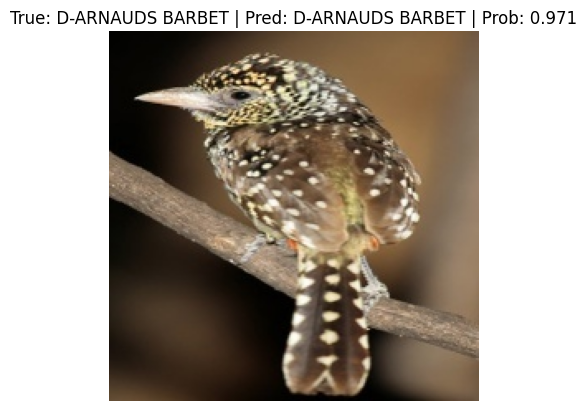

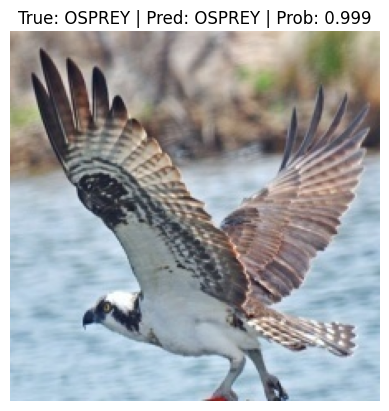

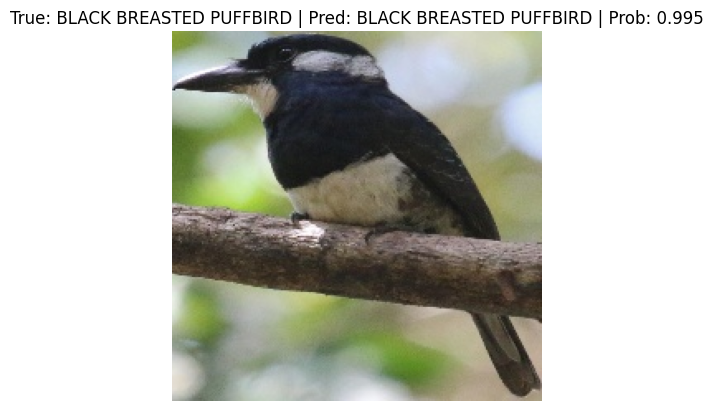

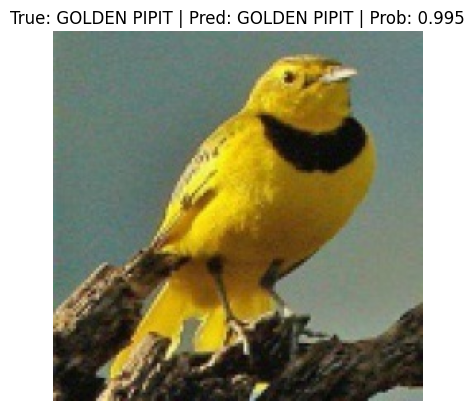

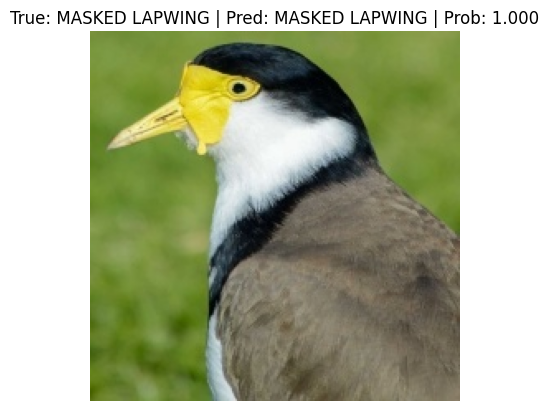

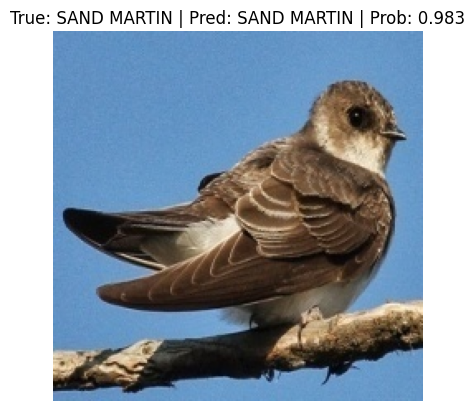

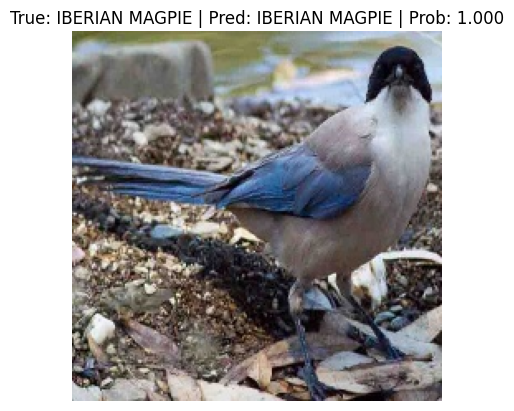

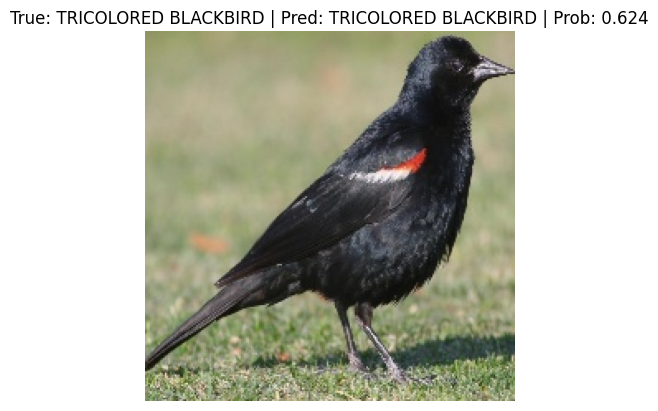

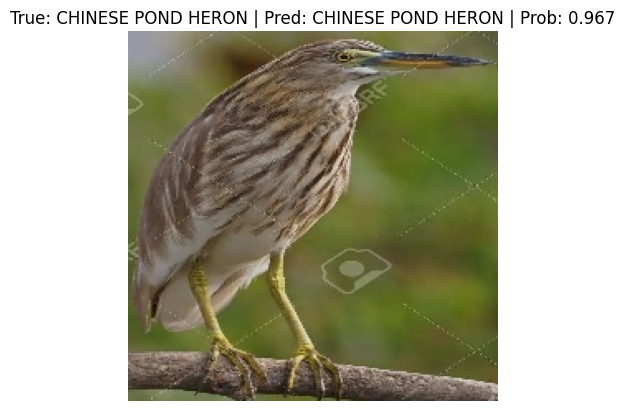

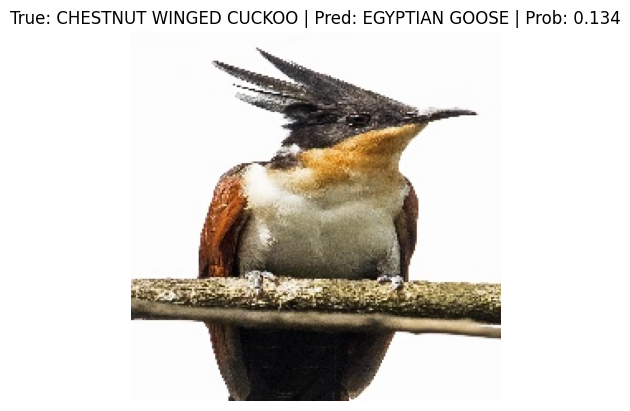

In [ ]:
# Predict Birds with the Test Set

num_images_to_plot = 10

test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))               # get all test image paths
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)              # randomly select k number of images

# Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    # Extract the true label from the image path (modify this part as needed)
    true_label = image_path.parent.name

    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        true_label=true_label,  # Pass the true label
                        image_size=(224, 224))

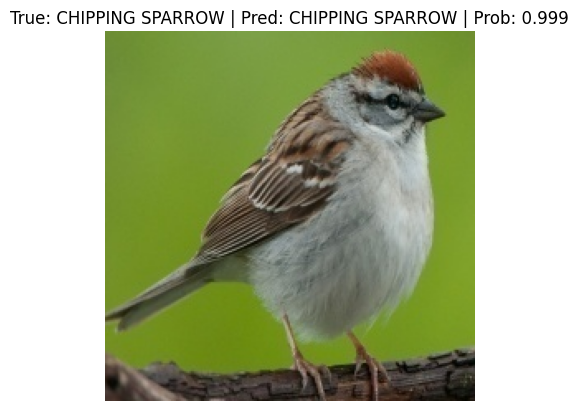

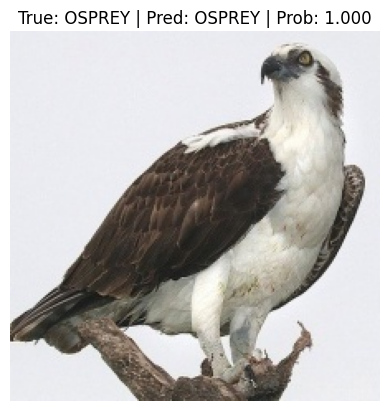

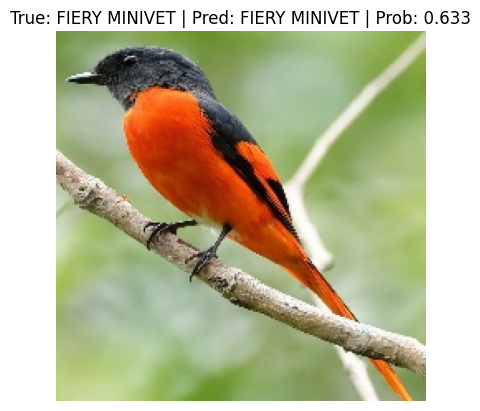

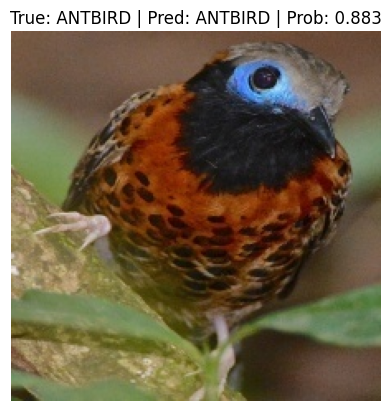

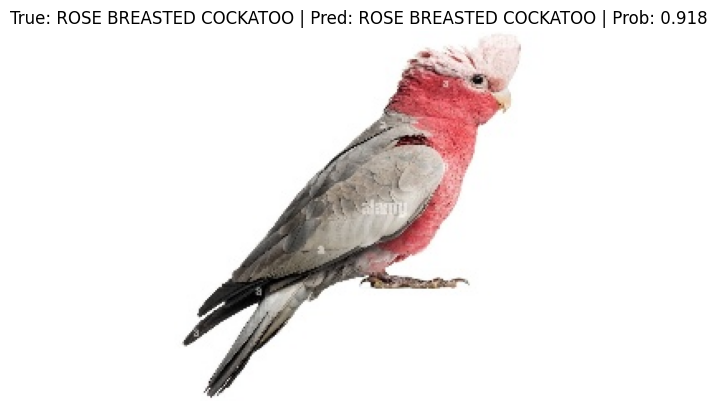

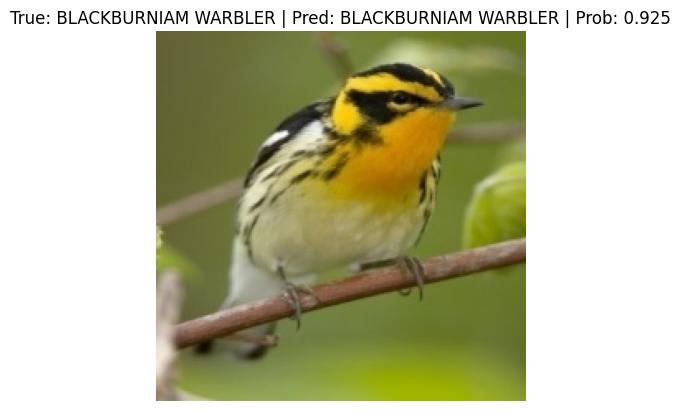

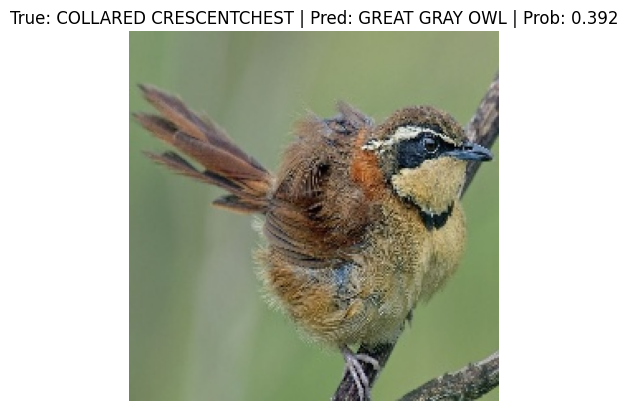

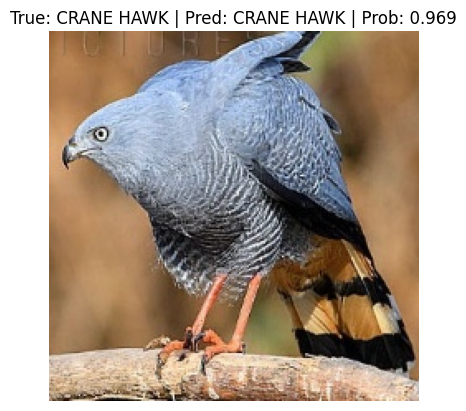

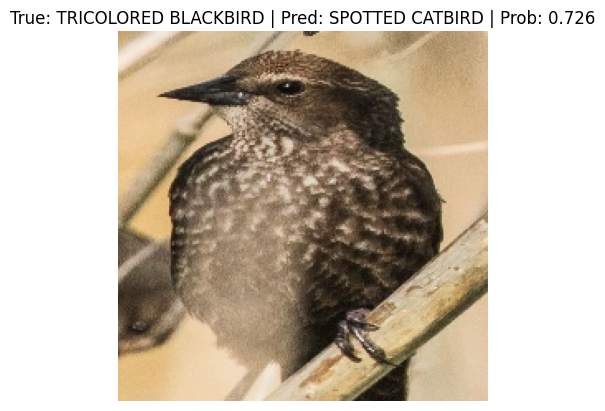

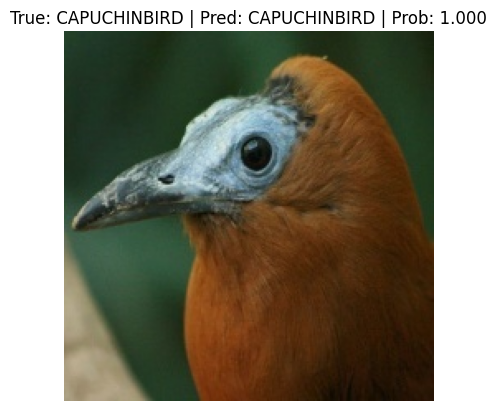

In [ ]:
# Predict Birds with the Validation Set

num_images_to_plot = 10

val_image_path_list = list(Path(valid_dir).glob("*/*.jpg"))               # get all test image paths
val_image_path_sample = random.sample(population=val_image_path_list,
                                       k=num_images_to_plot)              # randomly select k number of images

# Iterate through random test image paths, make predictions on them and plot them
for image_path in val_image_path_sample:
    # Extract the true label from the image path (modify this part as needed)
    true_label = image_path.parent.name

    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        true_label=true_label,  # Pass the true label
                        image_size=(224, 224))

#  Model Improvement

In order to improve the model we will create an EffNetB2 feature extractor using pretrained weights of EffNetB2

## Set up Model

In [ ]:
# Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# Get EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# Setup pretrained model
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# Freeze the base layers in the model (this will freeze all layers to begin with)
for param in effnetb2.parameters():
    param.requires_grad = False

# Check out EffNetB2 classifier head
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [ ]:
# Update the classifier head

OUT_FEATURES = len(class_names)

effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),             # keep dropout layer same
    nn.Linear(in_features=1408,                  # keep in_features same
              out_features=OUT_FEATURES))        # change out_features to suit our number of classes

We create our customized model to improve the previous results

In [ ]:
def create_effnetb2_model(num_classes:int=525,
                          seed:int=42):

    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

In [ ]:
# Setup DataLoaders

effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=len(class_names),
                                                      seed=42)

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

## Train Model

We train the model with the customized pretrained weights

In [ ]:
# Train the model (uncomment to train your own model)

# Setup optimizer
# optimizer = torch.optim.Adam(params=effnetb2.parameters(),
#                              lr=1e-3)
# Setup loss function
# loss_fn = torch.nn.CrossEntropyLoss()

# Set seeds for reproducibility and train the model
# set_seeds()

# epochs=10

# effnetb2_results = train(model=effnetb2.to(device),
#                                 train_dataloader=train_dataloader_effnetb2,
#                                 test_dataloader=test_dataloader_effnetb2,
#                                 epochs=10,
#                                 optimizer=optimizer,
#                                 loss_fn=loss_fn,
#                                 device=device,
#                                 writer=create_writer(experiment_name="effnetb2",
#                                                     model_name="effnetb2_10_epochs",
#                                                     extra=f"{epochs}_epochs"))

In [ ]:
# save_filepath = f"best_effnetb2_{epochs}_epochs.pth"

# save_model(model=effnetb2,
#             target_dir="models",
#             model_name=save_filepath)

In [ ]:
# Load the effnetb2_results of your pretrained model

with open('/content/effnetb2_results.csv', 'r') as file:
    reader = csv.reader(file)
    headers = next(reader) # Read the header row

    data = []
    for row in reader:
        record = {}
        for i, value in enumerate(row):
            record[headers[i]] = value
        data.append(record)

for entry in data:
    for key, value in entry.items():
        entry[key] = ast.literal_eval(value)

# Now, data_dict contains lists instead of string representations
print(data)

[{'train_loss': [1.7153321610055934, 0.6100465783803585, 0.45358886063267917, 0.37482739754570454, 0.3313172403180757, 0.2954154725927712, 0.2707555835732102, 0.2546093880852054, 0.24606784612841778, 0.23147594039935782], 'train_acc': [0.7042940033606385, 0.8618725057760975, 0.8887221697122453, 0.9033133795421129, 0.9114226703073585, 0.9190549954491354, 0.9241782188615836, 0.9290598963803123, 0.9289233704403836, 0.9321155394524959], 'test_loss': [0.4006889220551554, 0.2868648542158575, 0.23344691867900855, 0.193422128682036, 0.19814814736292394, 0.18370263607112175, 0.19144602683695391, 0.1796416969730025, 0.17951483746811028, 0.16938896823222718], 'test_acc': [0.9273343373493976, 0.9363704819277109, 0.9446536144578314, 0.9525602409638554, 0.9480421686746988, 0.9525602409638554, 0.9476656626506024, 0.9503012048192772, 0.9518072289156626, 0.9529367469879518]}]


In [ ]:
# Get the results as dictionary

effnetb2_results = data[0]
effnetb2_results

{'train_loss': [1.7153321610055934,
  0.6100465783803585,
  0.45358886063267917,
  0.37482739754570454,
  0.3313172403180757,
  0.2954154725927712,
  0.2707555835732102,
  0.2546093880852054,
  0.24606784612841778,
  0.23147594039935782],
 'train_acc': [0.7042940033606385,
  0.8618725057760975,
  0.8887221697122453,
  0.9033133795421129,
  0.9114226703073585,
  0.9190549954491354,
  0.9241782188615836,
  0.9290598963803123,
  0.9289233704403836,
  0.9321155394524959],
 'test_loss': [0.4006889220551554,
  0.2868648542158575,
  0.23344691867900855,
  0.193422128682036,
  0.19814814736292394,
  0.18370263607112175,
  0.19144602683695391,
  0.1796416969730025,
  0.17951483746811028,
  0.16938896823222718],
 'test_acc': [0.9273343373493976,
  0.9363704819277109,
  0.9446536144578314,
  0.9525602409638554,
  0.9480421686746988,
  0.9525602409638554,
  0.9476656626506024,
  0.9503012048192772,
  0.9518072289156626,
  0.9529367469879518]}

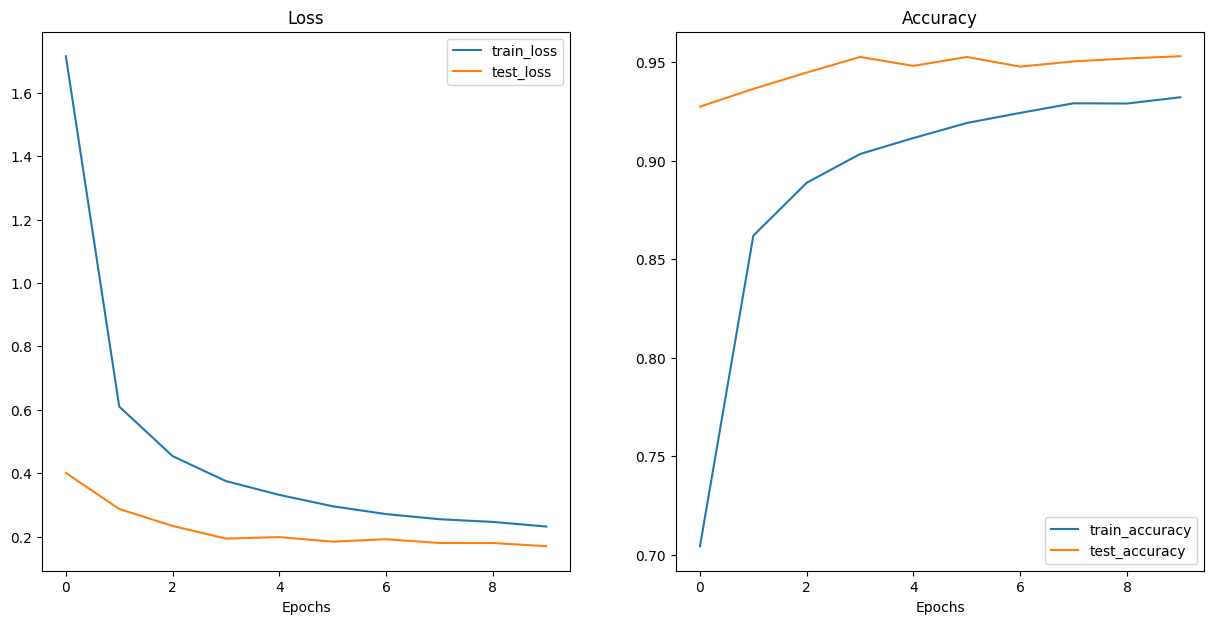

In [ ]:
# Plotting the Loss Curves

plot_loss_curves(effnetb2_results)

In [ ]:
# Count number of parameters in EffNetB2

effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

8440719

In [ ]:
# Get the model size in bytes then convert to megabytes

pretrained_effnetb2_model_size = Path("/content/best_effnetb2_10_epochs.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 32 MB


In [ ]:
# Create a dictionary with EffNetB2 statistics

effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.16938896823222718,
 'test_acc': 0.9529367469879518,
 'number_of_parameters': 8440719,
 'model_size (MB)': 32}

In [ ]:
# # Save EffNetB2 statistics

# csv_filename = "effnetb2_stats.csv"

# # Write the dictionary to a CSV file
# with open(csv_filename, 'w', newline='') as csvfile:
#     fieldnames = effnetb2_stats.keys()
#     writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

#     # Write the header row
#     writer.writeheader()

#     # Write the data
#     writer.writerow(effnetb2_stats)

# print(f"CSV file '{csv_filename}' has been created.")

## Predictions

In [ ]:
# Load the Best Model (effnetb2 with 10 epochs)

def load_best_effnetb2_model(model_path):
    # Create an instance of the EfficientNet-B2 model using your function
    model = create_effnetb2_model()[0]

    # Load the saved best model state_dict() into the model
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

    # Set the model in evaluation mode
    model.eval()

    return model

# Specify the path to the saved model state dictionary
best_model_path = "/content/best_effnetb2_10_epochs.pth"

# Load the model
best_model = load_best_effnetb2_model(best_model_path)

In [ ]:
# Get all test data paths

print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: /content/data/test


[PosixPath('/content/data/test/LITTLE AUK/4.jpg'),
 PosixPath('/content/data/test/LITTLE AUK/3.jpg'),
 PosixPath('/content/data/test/LITTLE AUK/5.jpg'),
 PosixPath('/content/data/test/LITTLE AUK/1.jpg'),
 PosixPath('/content/data/test/LITTLE AUK/2.jpg')]

In [ ]:
# Make predictions across test dataset with EffNetB2

effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=best_model,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU

  0%|          | 0/2625 [00:00<?, ?it/s]

In [ ]:
# Inspect the first 10 prediction dictionaries
effnetb2_test_pred_dicts[:10]


[{'image_path': PosixPath('/content/data/test/LITTLE AUK/4.jpg'),
  'class_name': 'LITTLE AUK',
  'pred_prob': 0.9999,
  'pred_class': 'LITTLE AUK',
  'time_for_pred': 0.3124,
  'correct': True},
 {'image_path': PosixPath('/content/data/test/LITTLE AUK/3.jpg'),
  'class_name': 'LITTLE AUK',
  'pred_prob': 0.9999,
  'pred_class': 'LITTLE AUK',
  'time_for_pred': 0.0965,
  'correct': True},
 {'image_path': PosixPath('/content/data/test/LITTLE AUK/5.jpg'),
  'class_name': 'LITTLE AUK',
  'pred_prob': 0.9996,
  'pred_class': 'LITTLE AUK',
  'time_for_pred': 0.0926,
  'correct': True},
 {'image_path': PosixPath('/content/data/test/LITTLE AUK/1.jpg'),
  'class_name': 'LITTLE AUK',
  'pred_prob': 0.9993,
  'pred_class': 'LITTLE AUK',
  'time_for_pred': 0.0979,
  'correct': True},
 {'image_path': PosixPath('/content/data/test/LITTLE AUK/2.jpg'),
  'class_name': 'LITTLE AUK',
  'pred_prob': 0.9999,
  'pred_class': 'LITTLE AUK',
  'time_for_pred': 0.087,
  'correct': True},
 {'image_path': Posix

In [ ]:
# Turn the test_pred_dicts into a DataFrame

effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)

effnetb2_test_pred_df.head()

image_path  class_name  pred_prob  pred_class  \
0  /content/data/test/LITTLE AUK/4.jpg  LITTLE AUK     0.9999  LITTLE AUK   
1  /content/data/test/LITTLE AUK/3.jpg  LITTLE AUK     0.9999  LITTLE AUK   
2  /content/data/test/LITTLE AUK/5.jpg  LITTLE AUK     0.9996  LITTLE AUK   
3  /content/data/test/LITTLE AUK/1.jpg  LITTLE AUK     0.9993  LITTLE AUK   
4  /content/data/test/LITTLE AUK/2.jpg  LITTLE AUK     0.9999  LITTLE AUK   

   time_for_pred  correct  
0         0.3124     True  
1         0.0965     True  
2         0.0926     True  
3         0.0979     True  
4         0.0870     True

In [ ]:
# Check number of correct predictions

correct_counts_test = effnetb2_test_pred_df['correct'].value_counts()

correct_counts_test

True     2500
False     125
Name: correct, dtype: int64

In [ ]:
# Get the count of true values (correct predictions)
true_count_test = correct_counts_test.get(True, 0)

# Calculate the percentage of true values
percentage_true_test = (true_count_test / len(effnetb2_test_pred_df)) * 100

print(f"Percentage of true values in the test set: {percentage_true_test:.2f}%")

Percentage of true values in the test set: 95.24%


In [ ]:
# Get all validation data paths

print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {valid_dir}")
valid_data_paths = list(Path(valid_dir).glob("*/*.jpg"))
valid_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: /content/data/valid


[PosixPath('/content/data/valid/LITTLE AUK/4.jpg'),
 PosixPath('/content/data/valid/LITTLE AUK/3.jpg'),
 PosixPath('/content/data/valid/LITTLE AUK/5.jpg'),
 PosixPath('/content/data/valid/LITTLE AUK/1.jpg'),
 PosixPath('/content/data/valid/LITTLE AUK/2.jpg')]

In [ ]:
# Make predictions across test dataset with EffNetB2

effnetb2_valid_pred_dicts = pred_and_store(paths=valid_data_paths,
                                          model=best_model,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU

  0%|          | 0/2625 [00:00<?, ?it/s]

In [ ]:
# Inspect the first 10 prediction dictionaries
effnetb2_valid_pred_dicts[:5]


[{'image_path': PosixPath('/content/data/valid/LITTLE AUK/4.jpg'),
  'class_name': 'LITTLE AUK',
  'pred_prob': 0.9999,
  'pred_class': 'LITTLE AUK',
  'time_for_pred': 0.1025,
  'correct': True},
 {'image_path': PosixPath('/content/data/valid/LITTLE AUK/3.jpg'),
  'class_name': 'LITTLE AUK',
  'pred_prob': 1.0,
  'pred_class': 'LITTLE AUK',
  'time_for_pred': 0.0888,
  'correct': True},
 {'image_path': PosixPath('/content/data/valid/LITTLE AUK/5.jpg'),
  'class_name': 'LITTLE AUK',
  'pred_prob': 0.9994,
  'pred_class': 'LITTLE AUK',
  'time_for_pred': 0.0883,
  'correct': True},
 {'image_path': PosixPath('/content/data/valid/LITTLE AUK/1.jpg'),
  'class_name': 'LITTLE AUK',
  'pred_prob': 0.9999,
  'pred_class': 'LITTLE AUK',
  'time_for_pred': 0.0988,
  'correct': True},
 {'image_path': PosixPath('/content/data/valid/LITTLE AUK/2.jpg'),
  'class_name': 'LITTLE AUK',
  'pred_prob': 0.9991,
  'pred_class': 'LITTLE AUK',
  'time_for_pred': 0.125,
  'correct': True}]

In [ ]:
effnetb2_valid_pred_df = pd.DataFrame(effnetb2_valid_pred_dicts)
effnetb2_valid_pred_df.head()

image_path  class_name  pred_prob  pred_class  \
0  /content/data/valid/LITTLE AUK/4.jpg  LITTLE AUK     0.9999  LITTLE AUK   
1  /content/data/valid/LITTLE AUK/3.jpg  LITTLE AUK     1.0000  LITTLE AUK   
2  /content/data/valid/LITTLE AUK/5.jpg  LITTLE AUK     0.9994  LITTLE AUK   
3  /content/data/valid/LITTLE AUK/1.jpg  LITTLE AUK     0.9999  LITTLE AUK   
4  /content/data/valid/LITTLE AUK/2.jpg  LITTLE AUK     0.9991  LITTLE AUK   

   time_for_pred  correct  
0         0.1086     True  
1         0.0953     True  
2         0.0863     True  
3         0.0934     True  
4         0.0860     True

In [ ]:
# Check number of correct predictions

correct_counts_valid = effnetb2_valid_pred_df.correct.value_counts()

correct_counts_valid

True     2447
False     178
Name: correct, dtype: int64

In [ ]:
# Get the count of true values (correct predictions)
true_count_valid = correct_counts_valid.get(True, 0)

# Calculate the percentage of true values
percentage_true_valid = (true_count_valid / len(effnetb2_test_pred_df)) * 100

print(f"Percentage of true values in the validation set: {percentage_true_valid:.2f}%")

Percentage of true values in the validation set: 93.22%


# Gradio App

We are going to deploy our model into a Gradio App. In order to use it the pretrained model must be available.

In [ ]:
# Import/install Gradio

try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.8/298.8 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 9.7 MB/s eta 0:

In [ ]:
# Put EffNetB2 on CPU
best_model.to("cpu")

# Check the device
next(iter(best_model.parameters())).device

device(type='cpu')

In [ ]:
# Prediction Function for the Gradio App

def predict(input_image, model=best_model, transform=effnetb2_transforms, class_names=class_names):

    # Create a dictionary to store prediction information
    pred_dict = {}

    # Start the prediction timer
    start_time = timer()

    # Preprocess the input image
    input_image = transform(input_image).unsqueeze(0)  # Add batch dimension

    # Prepare the model for inference
    model.eval()

    # Get prediction probability, prediction label, and prediction class
    with torch.inference_mode():
        pred_logit = model(input_image)               # perform inference on the input image
        pred_prob = torch.softmax(pred_logit, dim=1)  # convert logits into prediction probabilities
        pred_label = torch.argmax(pred_prob, dim=1)   # convert prediction probabilities into prediction label
        pred_class = class_names[pred_label.cpu()]    # get the predicted class (on CPU)

        # Store prediction information in the dictionary
        pred_dict["pred_prob"] = round(pred_prob.max().cpu().item(), 4)
        pred_dict["pred_class"] = pred_class

        # End the timer and calculate the time for predictionFtimer
        end_time = timer()
        pred_dict["time_for_pred"] = round(end_time - start_time, 4)

    return pred_class, pred_dict["pred_prob"], pred_dict["time_for_pred"]


In [ ]:
## Deploy Gradio App

# Create title, description and article strings
title = "Birds Prediction 🕊️🦅🦆"
description = "An EfficientNetB2 Computer Vision Model to Classify Birds."
article = "Created by Jayson"

# Create the Gradio demo
demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[
                        gr.Label(num_top_classes=525, label="Predicted Bird"),
                        gr.Number(label="Prediction Probability"),
                        gr.Number(label="Prediction Time (s)")
                    ],
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=True, # print errors locally?
            share=True) # generate a publically shareable URL?

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://d2fb8827c1eabc14ff.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://d2fb8827c1eabc14ff.gradio.live
